In [1]:
## Import libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import re, nltk, os

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

## Enable inline plotting (Kaggle compatibility)
#%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, Dropout

2026-01-02 16:07:39.178360: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-02 16:07:39.219839: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-02 16:07:40.219049: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [3]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [4]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

In [5]:
data = pd.read_csv("../data/fake_news_dataset.csv")
data.head(100)

,title,text,date,source,author,category,label
0,Foreign Democrat final.,more tax development both store agreement lawy...,2023-03-10,NY Times,Paula George,Politics,real
1,To offer down resource great point.,probably guess western behind likely next inve...,2022-05-25,Fox News,Joseph Hill,Politics,fake
2,Himself church myself carry.,them identify forward present success risk sev...,2022-09-01,CNN,Julia Robinson,Business,fake
3,You unit its should.,phone which item yard Republican safe where po...,2023-02-07,Reuters,Mr. David Foster DDS,Science,fake
4,Billion believe employee summer how.,wonder myself fact difficult course forget exa...,2023-04-03,CNN,Austin Walker,Technology,fake
...,...,...,...,...,...,...,...
95,White worker west away always.,consumer leader perhaps list program music pul...,2023-07-13,Global Times,Desiree Long,Business,fake
96,Peace what poor popular site three trouble.,use arm and trip result mouth under tree Mr fi...,2024-10-23,Daily News,Allison Contreras,Science,real
97,Few ask that but.,smile mouth serious concern conference make me...,2022-05-25,NY Times,Heidi Mcclain,Science,real
98,Guess against receive doctor.,challenge poor in design different beyond hit ...,2023-12-22,BBC,Donna Martinez,Sports,fake


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     20000 non-null  object
 1   text      20000 non-null  object
 2   date      20000 non-null  object
 3   source    19000 non-null  object
 4   author    19000 non-null  object
 5   category  20000 non-null  object
 6   label     20000 non-null  object
dtypes: object(7)
memory usage: 1.1+ MB


In [7]:
data.describe()

,title,text,date,source,author,category,label
count,20000,20000,20000,19000,19000,20000,20000
unique,20000,20000,1096,8,17051,7,2
top,Foreign Democrat final.,more tax development both store agreement lawy...,2023-08-31,Daily News,Michael Smith,Health,fake
freq,1,1,32,2439,12,2922,10056


In [8]:
# missing values
data.isnull().sum()
print("Missing values in each column:")
print(data.isnull().sum())

Missing values in each column:
title          0
text           0
date           0
source      1000
author      1000
category       0
label          0
dtype: int64


In [9]:
data.columns

Index(['title', 'text', 'date', 'source', 'author', 'category', 'label'], dtype='object')

## Data preprocessing

In [10]:
## Check for missing values in 'source' and 'author'
missing_counts = data[['source', 'author']].isnull().sum()

## Calculate percentage of missing values
missing_percent = data[['source', 'author']].isnull().mean() * 100

In [11]:
## Combine into a summary DataFrame
missing_summary = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing Percentage': missing_percent
})

print(missing_summary)

        Missing Count  Missing Percentage
source           1000                 5.0
author           1000                 5.0


In [12]:
## Fill missing values with 'Unknown'
data['source'] = data['source'].fillna('Unknown')
data['author'] = data['author'].fillna('Unknown')

In [13]:
# convert column "date" to datetime
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   title     20000 non-null  object        
 1   text      20000 non-null  object        
 2   date      20000 non-null  datetime64[ns]
 3   source    20000 non-null  object        
 4   author    20000 non-null  object        
 5   category  20000 non-null  object        
 6   label     20000 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 1.1+ MB


## Clean Data

In [14]:
## Capitalization Ratio (from RAW text) - BEFORE cleaning

def calculate_cap_ratio(text):
    """Calculate the ratio of uppercase letters to total letters"""
    if pd.isnull(text) or len(text) == 0:
        return 0
    
    uppercase_count = sum(1 for c in text if c.isupper())
    total_letters = sum(1 for c in text if c.isalpha())
    
    return uppercase_count / total_letters if total_letters > 0 else 0

def calculate_consecutive_caps(text):
    """Calculate the maximum consecutive uppercase letters"""
    if pd.isnull(text):
        return 0
    
    max_consecutive = 0
    current_consecutive = 0
    
    for c in text:
        if c.isupper():
            current_consecutive += 1
            max_consecutive = max(max_consecutive, current_consecutive)
        else:
            current_consecutive = 0
    
    return max_consecutive

def calculate_punctuation_count(text):
    """Calculate total punctuation count"""
    if pd.isnull(text):
        return 0
    
    punctuation = '!?.,;:()-\'"'
    return sum(1 for c in text if c in punctuation)

def calculate_exclamation_count(text):
    """Calculate exclamation mark count"""
    if pd.isnull(text):
        return 0
    return text.count('!')

def calculate_question_count(text):
    """Calculate question mark count"""
    if pd.isnull(text):
        return 0
    return text.count('?')

def calculate_punctuation_ratio(text):
    """Calculate ratio of punctuation to total characters"""
    if pd.isnull(text) or len(text) == 0:
        return 0
    
    punctuation = '!?.,;:()-\'"'
    punct_count = sum(1 for c in text if c in punctuation)
    return punct_count / len(text) if len(text) > 0 else 0

# Apply capitalization features from RAW text (before cleaning)
data['cap_ratio_text'] = data['text'].apply(calculate_cap_ratio)
data['cap_ratio_title'] = data['title'].apply(calculate_cap_ratio)
data['cap_ratio_combined'] = (data['cap_ratio_text'] + data['cap_ratio_title']) / 2

data['max_consecutive_caps_text'] = data['text'].apply(calculate_consecutive_caps)
data['max_consecutive_caps_title'] = data['title'].apply(calculate_consecutive_caps)

# Apply punctuation features from RAW text (Emotion Signal)
data['punct_count_text'] = data['text'].apply(calculate_punctuation_count)
data['punct_count_title'] = data['title'].apply(calculate_punctuation_count)
data['exclamation_count_text'] = data['text'].apply(calculate_exclamation_count)
data['exclamation_count_title'] = data['title'].apply(calculate_exclamation_count)
data['question_count_text'] = data['text'].apply(calculate_question_count)
data['question_count_title'] = data['title'].apply(calculate_question_count)
data['punct_ratio_text'] = data['text'].apply(calculate_punctuation_ratio)
data['punct_ratio_title'] = data['title'].apply(calculate_punctuation_ratio)

print("Capitalization Features Created:")
print(data[['cap_ratio_text', 'cap_ratio_title', 'cap_ratio_combined', 
            'max_consecutive_caps_text', 'max_consecutive_caps_title']].describe())

print("\nPunctuation Features Created (Emotion Signal):")
print(data[['punct_count_text', 'punct_count_title', 'exclamation_count_text', 
            'exclamation_count_title', 'question_count_text', 'question_count_title',
            'punct_ratio_text', 'punct_ratio_title']].describe())

Capitalization Features Created:
       cap_ratio_text  cap_ratio_title  cap_ratio_combined  \
count    20000.000000     20000.000000        20000.000000   
mean         0.002043         0.038258            0.020151   
std          0.001412         0.016861            0.008467   
min          0.000000         0.015385            0.007937   
25%          0.000855         0.027027            0.014641   
50%          0.001854         0.034483            0.018007   
75%          0.002886         0.045455            0.023321   
max          0.009533         0.250000            0.127437   

       max_consecutive_caps_text  max_consecutive_caps_title  
count               20000.000000                20000.000000  
mean                    1.297800                    1.008600  
std                     0.645319                    0.092339  
min                     0.000000                    1.000000  
25%                     1.000000                    1.000000  
50%                     1.0000

In [15]:
## Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if pd.isnull(text):
        return ""

    ## Lowercase
    text = text.lower()
    
    ## Remove punctuation and non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)
    
    ## Tokenize
    tokens = word_tokenize(text)
    
    ## Remove stopwords and lemmatize
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    ## Join back into a string
    return ' '.join(cleaned_tokens)

In [16]:
# Download required NLTK resource
# nltk.download('punkt_tab')

data['cleaned_text'] = data['text'].apply(clean_text)
data['cleaned_title'] = data['title'].apply(clean_text)

In [17]:
data.head()

,title,text,date,source,author,category,label,cap_ratio_text,cap_ratio_title,cap_ratio_combined,...,punct_count_text,punct_count_title,exclamation_count_text,exclamation_count_title,question_count_text,question_count_title,punct_ratio_text,punct_ratio_title,cleaned_text,cleaned_title
0,Foreign Democrat final.,more tax development both store agreement lawy...,2023-03-10,NY Times,Paula George,Politics,real,0.000820,0.100000,0.050410,...,0,1,0,0,0,0,0.0,0.043478,tax development store agreement lawyer hear ou...,foreign democrat final
1,To offer down resource great point.,probably guess western behind likely next inve...,2022-05-25,Fox News,Joseph Hill,Politics,fake,0.001480,0.034483,0.017982,...,0,1,0,0,0,0,0.0,0.028571,probably guess western behind likely next inve...,offer resource great point
2,Himself church myself carry.,them identify forward present success risk sev...,2022-09-01,CNN,Julia Robinson,Business,fake,0.001599,0.041667,0.021633,...,0,1,0,0,0,0,0.0,0.035714,identify forward present success risk several ...,church carry
3,You unit its should.,phone which item yard Republican safe where po...,2023-02-07,Reuters,Mr. David Foster DDS,Science,fake,0.003539,0.062500,0.033019,...,0,1,0,0,0,0,0.0,0.050000,phone item yard republican safe police identif...,unit
4,Billion believe employee summer how.,wonder myself fact difficult course forget exa...,2023-04-03,CNN,Austin Walker,Technology,fake,0.001630,0.032258,0.016944,...,0,1,0,0,0,0,0.0,0.027778,wonder fact difficult course forget exactly pa...,billion believe employee summer


In [18]:
data.columns

Index(['title', 'text', 'date', 'source', 'author', 'category', 'label',
       'cap_ratio_text', 'cap_ratio_title', 'cap_ratio_combined',
       'max_consecutive_caps_text', 'max_consecutive_caps_title',
       'punct_count_text', 'punct_count_title', 'exclamation_count_text',
       'exclamation_count_title', 'question_count_text',
       'question_count_title', 'punct_ratio_text', 'punct_ratio_title',
       'cleaned_text', 'cleaned_title'],
      dtype='object')

## Exploratory Data Analysis

In [19]:
## Count of each label
label_counts = data['label'].value_counts()

## Percentage distribution
label_percent = data['label'].value_counts(normalize=True) * 100

## Combine into a summary table
label_summary = pd.DataFrame({
    'Count': label_counts,
    'Percentage': label_percent.round(2)
})

print(label_summary)

       Count  Percentage
label                   
fake   10056       50.28
real    9944       49.72


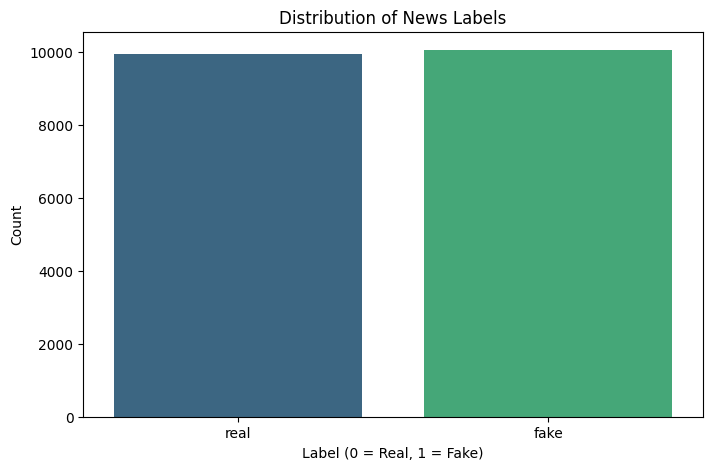

In [20]:
# plot label distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=data, palette='viridis')
plt.title('Distribution of News Labels')
plt.xlabel('Label (0 = Real, 1 = Fake)')
plt.ylabel('Count')
plt.show()

In [21]:
# Add new columns for text length and title length
data['text_count'] = data['cleaned_text'].apply(lambda x: len(x.split()))
data['title_count'] = data['cleaned_title'].apply(lambda x: len(x.split()))

In [22]:
## Descriptive stats
print("Title Word Count Stats:")
print(data['title_count'].describe())

print("\nText Word Count Stats:")
print(data['text_count'].describe())

Title Word Count Stats:
count    20000.00000
mean         4.91625
std          1.48669
min          0.00000
25%          4.00000
50%          5.00000
75%          6.00000
max          8.00000
Name: title_count, dtype: float64

Text Word Count Stats:
count    20000.000000
mean       223.949650
std         26.486955
min        167.000000
25%        201.000000
50%        224.000000
75%        246.000000
max        283.000000
Name: text_count, dtype: float64


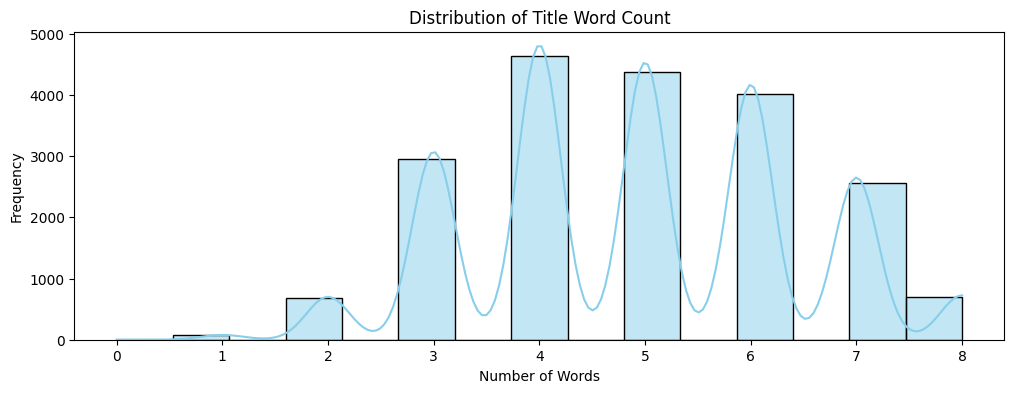

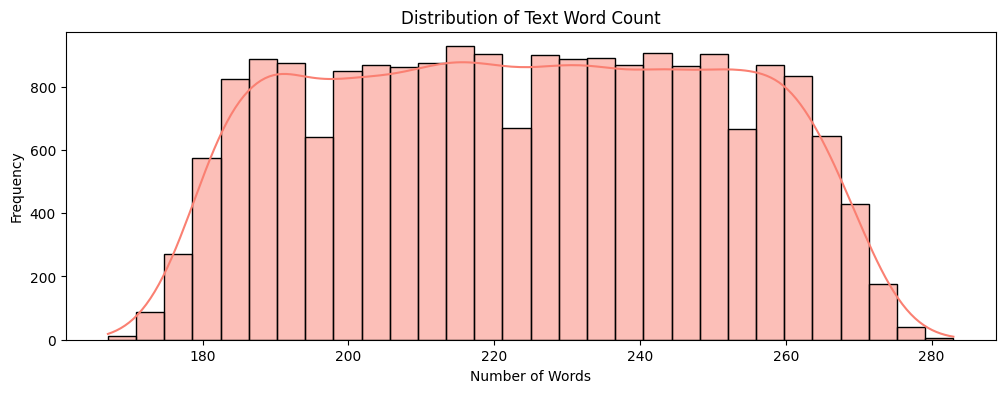

In [23]:
## Visualize the text length in a plot

# Title word count
plt.figure(figsize=(12, 4))
sns.histplot(data['title_count'], bins=15, kde=True, color='skyblue')
plt.title('Distribution of Title Word Count')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# Text word count
plt.figure(figsize=(12, 4))
sns.histplot(data['text_count'], bins=30, kde=True, color='salmon')
plt.title('Distribution of Text Word Count')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

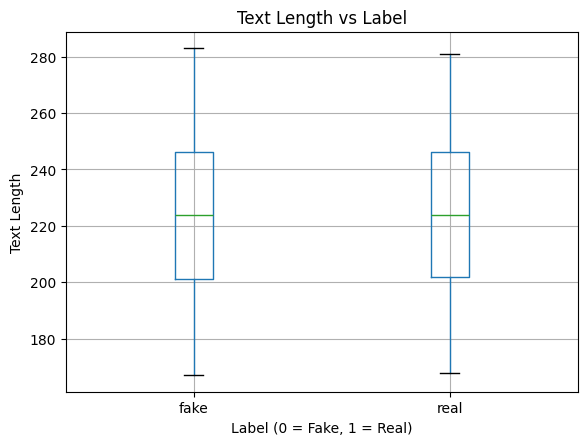

In [24]:
data.boxplot(column="text_count", by="label")
plt.xlabel("Label (0 = Fake, 1 = Real)")
plt.ylabel("Text Length")
plt.title("Text Length vs Label")
plt.suptitle("")
plt.show()


In [25]:
## Count of articles per category
category_counts = data['category'].value_counts()

## Percentage distribution
category_percent = data['category'].value_counts(normalize=True) * 100

## Combine into a summary table
category_summary = pd.DataFrame({
    'Count': category_counts,
    'Percentage': category_percent.round(2)
})

print(category_summary)

               Count  Percentage
category                        
Health          2922       14.61
Entertainment   2889       14.44
Technology      2882       14.41
Sports          2867       14.34
Business        2849       14.24
Politics        2802       14.01
Science         2789       13.94


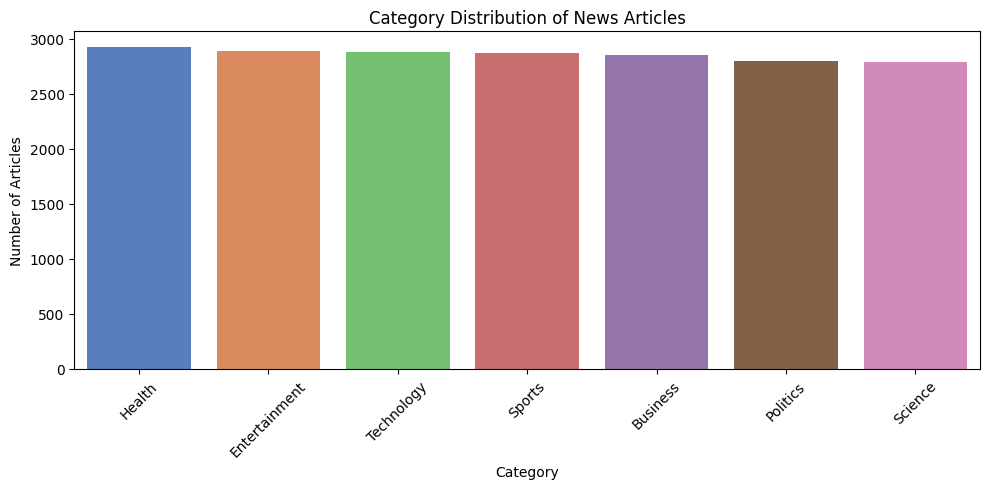

In [26]:
## Category Distribution

plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='category', order=data['category'].value_counts().index, palette='muted')
plt.title('Category Distribution of News Articles')
plt.ylabel('Number of Articles')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
## Compare real vs fake over category

category_label_crosstab = pd.crosstab(data['category'], data['label'])
print(category_label_crosstab)

label          fake  real
category                 
Business       1471  1378
Entertainment  1460  1429
Health         1482  1440
Politics       1399  1403
Science        1376  1413
Sports         1444  1423
Technology     1424  1458


In [28]:
## Normalize by row to get % of fake/real within each category
category_label_percent = pd.crosstab(data['category'], data['label'], normalize='index') * 100
print(category_label_percent.round(2))

label           fake   real
category                   
Business       51.63  48.37
Entertainment  50.54  49.46
Health         50.72  49.28
Politics       49.93  50.07
Science        49.34  50.66
Sports         50.37  49.63
Technology     49.41  50.59


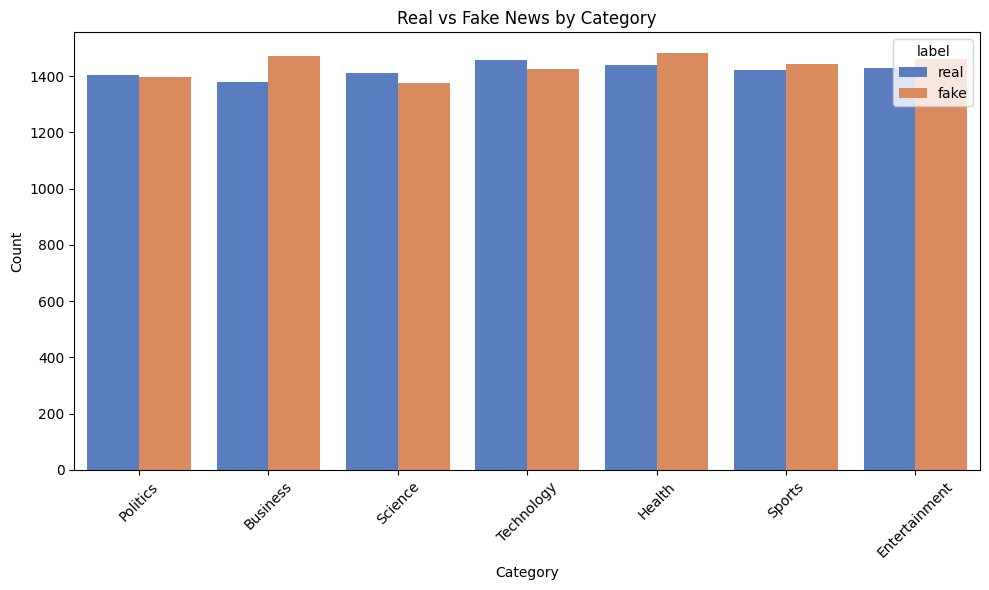

In [29]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='category', hue='label', palette='muted')
plt.title('Real vs Fake News by Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [30]:
# Extract Time Features

data["year"] = data["date"].dt.year
data["month"] = data["date"].dt.month
data["day"] = data["date"].dt.day


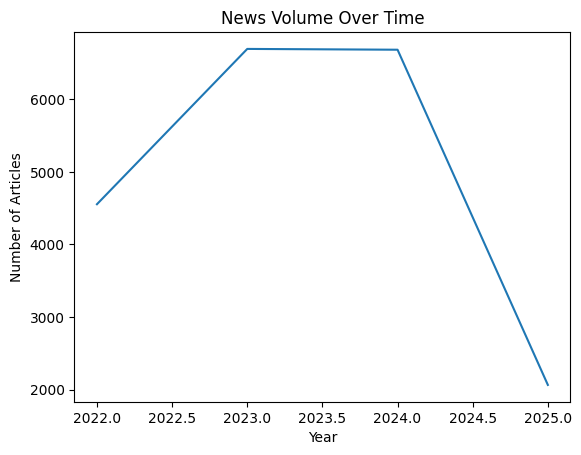

In [31]:
# Number of Articles Over Time : By Year

data["year"].value_counts().sort_index().plot(kind="line")
plt.xlabel("Year")
plt.ylabel("Number of Articles")
plt.title("News Volume Over Time")
plt.show()


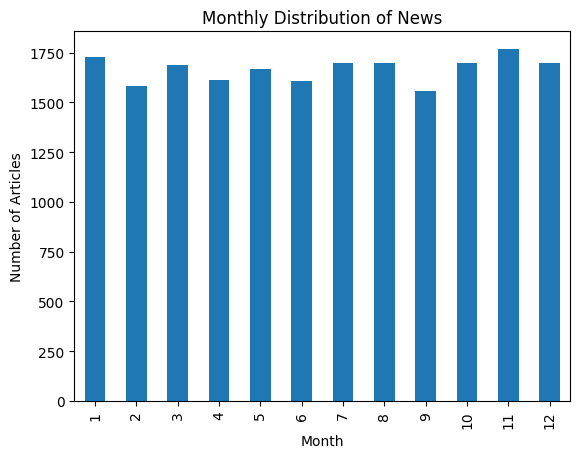

In [32]:
data["month"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("Month")
plt.ylabel("Number of Articles")
plt.title("Monthly Distribution of News")
plt.show()

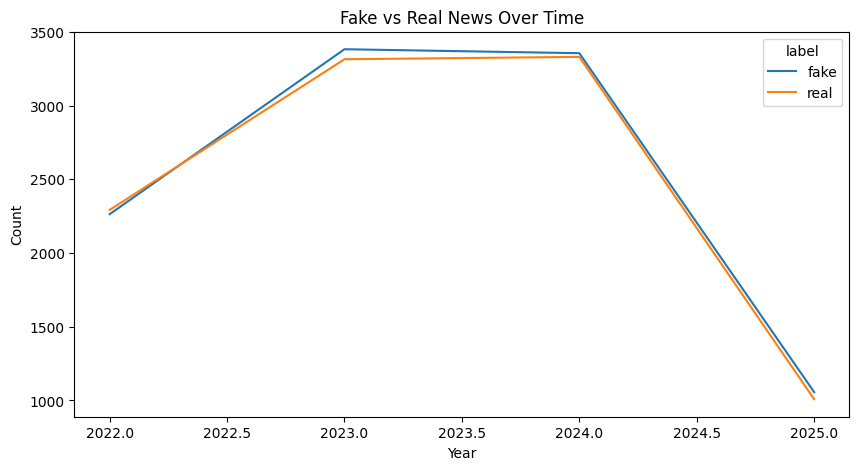

In [33]:
# Fake vs Real Over Time

time_label = data.groupby("year")["label"].value_counts().unstack()
time_label.plot(kind="line", figsize=(10,5))

plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Fake vs Real News Over Time")
plt.show()

# Feature Engineering

In [34]:
data["final_text"] = data["cleaned_title"] + " " + data["cleaned_text"]


In [35]:
X = data["final_text"]
y = data["label"]


In [36]:
# split training set 70% and testing set 20%

from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=42,
    stratify=y
)


In [37]:
# split validation set 10% from training set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.125,   # gives 10% of total data
    random_state=42,
    stratify=y_train_val
)

In [38]:
print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

print("\nClass distribution:")
print("Train:\n", y_train.value_counts(normalize=True))
print("Validation:\n", y_val.value_counts(normalize=True))
print("Test:\n", y_test.value_counts(normalize=True))


Train size: 14000
Validation size: 2000
Test size: 4000

Class distribution:
Train:
 label
fake    0.502786
real    0.497214
Name: proportion, dtype: float64
Validation:
 label
fake    0.503
real    0.497
Name: proportion, dtype: float64
Test:
 label
fake    0.50275
real    0.49725
Name: proportion, dtype: float64


### Tokenization (FIT ONLY ON TRAIN ❗)

In [39]:
vocab_size = 20000
max_len = 300

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq   = tokenizer.texts_to_sequences(X_val)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

### Padding

In [40]:
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post")
X_val_pad   = pad_sequences(X_val_seq, maxlen=max_len, padding="post")
X_test_pad  = pad_sequences(X_test_seq, maxlen=max_len, padding="post")
print("Padded training data shape:", X_train_pad.shape)
print("Padded validation data shape:", X_val_pad.shape)
print("Padded test data shape:", X_test_pad.shape)


Padded training data shape: (14000, 300)
Padded validation data shape: (2000, 300)
Padded test data shape: (4000, 300)


In [41]:
embedding_dim = 100

model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_len
    ),
    GlobalAveragePooling1D(),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


E0000 00:00:1767344889.231420   12083 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1767344889.237367   12083 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [43]:
# Convert labels to numerical format (0 and 1)
y_train_numeric = y_train.map({'real': 0, 'fake': 1})
y_val_numeric = y_val.map({'real': 0, 'fake': 1})

history = model.fit(
    X_train_pad, y_train_numeric,
    validation_data=(X_val_pad, y_val_numeric),
    epochs=10,
    batch_size=32
)


Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.4958 - loss: 0.6936 - val_accuracy: 0.5030 - val_loss: 0.6932
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5016 - loss: 0.6934 - val_accuracy: 0.4970 - val_loss: 0.6933
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5076 - loss: 0.6931 - val_accuracy: 0.4970 - val_loss: 0.6937
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4981 - loss: 0.6933 - val_accuracy: 0.4970 - val_loss: 0.6933
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5087 - loss: 0.6925 - val_accuracy: 0.4970 - val_loss: 0.6956
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5253 - loss: 0.6916 - val_accuracy: 0.5055 - val_loss: 0.6958
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5358 - loss: 0.6897 - val_accuracy: 0.5060 - val_loss: 0.6962
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5596 - loss: 0.6835 - val_accu

In [45]:
# Convert y_test to numerical format (0 and 1)
y_test_numeric = y_test.map({'real': 0, 'fake': 1})

y_pred = (model.predict(X_test_pad) > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test_numeric, y_pred))
print(classification_report(y_test_numeric, y_pred))


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
Accuracy: 0.5035
              precision    recall  f1-score   support

           0       0.50      0.30      0.37      1989
           1       0.50      0.71      0.59      2011

    accuracy                           0.50      4000
   macro avg       0.50      0.50      0.48      4000
weighted avg       0.50      0.50      0.48      4000



In [46]:
sample_text = ["Breaking: miracle cure discovered overnight"]

seq = tokenizer.texts_to_sequences(sample_text)
pad = pad_sequences(seq, maxlen=max_len, padding="post")

prediction = model.predict(pad)

print("Fake News" if prediction < 0.5 else "Real News")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Real News


In [47]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, Conv1D, GlobalMaxPooling1D,
    Dense, Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [48]:
MAX_WORDS = 20000
MAX_LEN = 300

def build_cnn():
    inputs = Input(shape=(MAX_LEN,))
    
    x = Embedding(input_dim=MAX_WORDS, output_dim=128)(inputs)
    x = Conv1D(filters=128, kernel_size=5, activation="relu")(x)
    x = GlobalMaxPooling1D()(x)
    
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [49]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True
)


In [51]:
cnn_model = build_cnn()

history_cnn = cnn_model.fit(
    X_train_pad,
    y_train_numeric,
    validation_data=(X_val_pad, y_val_numeric),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.4981 - loss: 0.6940 - val_accuracy: 0.4970 - val_loss: 0.6935
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.5290 - loss: 0.6905 - val_accuracy: 0.5120 - val_loss: 0.6937
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.5654 - loss: 0.6824 - val_accuracy: 0.4985 - val_loss: 0.6943
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.6696 - loss: 0.6289 - val_accuracy: 0.4945 - val_loss: 0.7238
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.8306 - loss: 0.4341 - val_accuracy: 0.5030 - val_loss: 0.8222
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.9469 - loss: 0.1947 - val_accuracy: 0.4940 - val_loss: 1.0053
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.9845 - loss: 0.0811 - val_accuracy: 0.4900 - val_loss: 1.2281
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9939 - loss: 0.0403 - val_accu

In [53]:
from sklearn.metrics import accuracy_score, classification_report

cnn_test_pred = (cnn_model.predict(X_test_pad) > 0.5).astype(int)

print("CNN Test Accuracy:", accuracy_score(y_test_numeric, cnn_test_pred))
print(classification_report(y_test_numeric, cnn_test_pred))


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
CNN Test Accuracy: 0.49725
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      1989
           1       0.00      0.00      0.00      2011

    accuracy                           0.50      4000
   macro avg       0.25      0.50      0.33      4000
weighted avg       0.25      0.50      0.33      4000

